In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from pathlib import Path
import pickle
import time
from sklearn.model_selection import train_test_split
pd.options.display.max_columns = 999

myseed = 42069  # set a random seed for reproducibility

！！設定要訓練哪個資料集！！

In [2]:
dataset_no = True
dataset_onehot = False
dataset_w2v = False
dataset_bert = False

In [3]:
load_PATH = Path('/home/hsien/110/sta/final_pkfile/')

In [4]:
for dirname, _, filenames in os.walk(load_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/hsien/110/sta/final_pkfile/imdb_df_genres_title_cgname.pk
/home/hsien/110/sta/final_pkfile/w2v_crew_arr_50.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew.wv.vectors.npy
/home/hsien/110/sta/final_pkfile/cast_onehot_df.pk
/home/hsien/110/sta/final_pkfile/w2v_cast_arr_50.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew.syn1neg.npy
/home/hsien/110/sta/final_pkfile/crew_onehot_df.pk
/home/hsien/110/sta/final_pkfile/bestw2v_model_crew
/home/hsien/110/sta/final_pkfile/bestw2v_model.wv.vectors.npy
/home/hsien/110/sta/final_pkfile/bestw2v_model
/home/hsien/110/sta/final_pkfile/bestw2v_model.syn1neg.npy
/home/hsien/110/sta/final_pkfile/crew_50_sparse_df.pk
/home/hsien/110/sta/final_pkfile/w2v_crew_arr.pk
/home/hsien/110/sta/final_pkfile/cast_50_sparse_df.pk
/home/hsien/110/sta/final_pkfile/w2v_cast_arr.pk


# Load
此檔已有
1. genres和titleType的one-hot
2. change_name欄位

還沒刪除['originalTitle', 'endYear', 'titleType', 'genres', 'cast', 'crew']

In [5]:
with open(load_PATH / 'imdb_df_genres_title_cgname.pk', 'rb') as f:
    imdb_df = pickle.load(f)

In [6]:
df = imdb_df.drop(columns=['originalTitle', 'endYear', 'titleType', 'genres', 'cast', 'crew', 'tconst', 'primaryTitle'], inplace=False)

In [7]:
def get_vec(wtv, cast_list): # 我用平均
    if (np.array(sum(wtv.wv[c] for c in cast_list if wtv.wv.has_index_for(c))).shape) == (300,):
        return np.array(sum(wtv.wv[c] for c in cast_list if wtv.wv.has_index_for(c))) / len(cast_list)
    else:
        return np.zeros((300,), dtype=float)

In [8]:
if dataset_no:
    X = np.array(df.drop(columns=['averageRating'], inplace=False).loc[:, :])
    y = np.ravel(df.loc[:, df.columns == 'averageRating'])
    
elif dataset_onehot:
    
    with open(load_PATH / 'cast_onehot_df.pk', 'rb') as f:
        cast_onehot_df = pickle.load(f)
    with open(load_PATH / 'crew_onehot_df.pk', 'rb') as f:
        crew_onehot_df = pickle.load(f)
    # 補上cast one hot
    df_one_hot = pd.concat((df, cast_onehot_df), axis=1)
    df_one_hot = pd.concat((df_one_hot, crew_onehot_df), axis=1)
    
    X = df_one_hot.drop(columns=['averageRating'], inplace=False).loc[:, :]
    y = np.ravel(df_one_hot.loc[:, df_one_hot.columns == 'averageRating'])
#     one_hot_data_arr = np.concatenate((X, y.reshape(-1,1)), axis=1)

elif dataset_w2v:
    wtv_cast = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/cast_50_model')
    wtv_crew = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/crew_50_model')

    w2v_cast_arr = np.asarray(list(get_vec(wtv_cast, x) for x in imdb_df['cast']), dtype="float64")
    w2v_crew_arr = np.asarray(list(get_vec(wtv_crew, x) for x in imdb_df['crew']), dtype="float64")
    
    X = np.array(df.drop(columns=['averageRating'], inplace=False).loc[:, :])
    y = np.ravel(df.loc[:, df.columns == 'averageRating'])
    
    X = np.concatenate((X, w2v_cast_arr), axis=1)
    X = np.concatenate((X, w2v_crew_arr), axis=1)
#     w2v_data_arr = np.concatenate((X,y.reshape(-1,1)), axis=1)

elif dataset_bert:
    wtv_cast = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/cast_50_model')
    wtv_crew = Word2Vec.load('/home/jack/0_Other HW/SLDL Project/model/crew_50_model')

    w2v_cast_arr = np.asarray(list(get_vec(wtv_cast, x) for x in imdb_df['cast']), dtype="float64")
    w2v_crew_arr = np.asarray(list(get_vec(wtv_crew, x) for x in imdb_df['crew']), dtype="float64")
    
    with open('/home/jack/0_Other HW/SLDL Project/model/df_bert.pk', 'rb') as f:
        df_bert = pickle.load(f)
        
    bert_arr = np.array(df_bert)
    X = np.array(df.drop(columns=['averageRating'], inplace=False).loc[:, :])
    y = np.ravel(df.loc[:, df.columns == 'averageRating'])
    X = np.concatenate((X, w2v_cast_arr), axis=1)
    X = np.concatenate((X, w2v_crew_arr), axis=1)
    X = np.concatenate((X, bert_arr), axis=1)
#     bert_data_arr = np.concatenate((X,y.reshape(-1,1)), axis=1)
    
else:
    print('YOU NEED SET ONE TYPE AS TRUE!')

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [10]:
tr_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis=1)
tt_data = np.concatenate((X_test, y_test.reshape(-1,1)), axis=1)
dv_data = np.concatenate((X_valid, y_valid.reshape(-1,1)), axis=1)

print(tr_data.shape)
print(dv_data.shape)
print(tt_data.shape)

(130252, 43)
(32564, 43)
(40705, 43)


# pytorch

In [11]:
# tr_path = 'covid.train.csv'  # path to training data
# tt_path = 'covid.test.csv'   # path to testing data

# !gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
# !gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

"""# **Import Some Packages**"""


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

"""# **Some Utilities**

You do not need to modify this part.
"""

def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [12]:
class myDataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 movies_arr,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
#         with open(path, 'r') as fp:
#             data = list(csv.reader(fp))
#             data = np.array(data[1:])[:, 1:].astype(float)
        data = movies_arr
    
#         if not target_only:
        feats = list(range(movies_arr.shape[1] - 1))
#         else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # f_regression
#             feats = list(range(40)) +[40, 42, 43, 57, 58, 60, 61, 75, 77, 78, 79]
# [57,75] + [42,43,44] + [42+18,43+18,44+18] + [42+18+18,43+18+18,44+18+18] 
            
#             pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]
            
            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # if mode != 'train':
        #     with open(tr_path, 'r') as fp:
        #         train_data = list(csv.reader(fp))
        #         train_data = np.array(train_data[1:])[:, 1:].astype(float)
        #         train_data = train_data[:, feats]
        #         train_data = torch.FloatTensor(train_data[[i for i in range(len(data)) if i % 10 != 0]])
        #     self.data[:, 40:] = \
        #         (self.data[:, 40:] - train_data[:, 40:].mean(dim=0, keepdim=True)) \
        #         / train_data[:, 40:].std(dim=0, keepdim=True)
        # else:
        #     self.data[:, 40:] = \
        #         (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        #         / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

"""## **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.

"""

def prep_dataloader(data, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = myDataset(data, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

"""# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.

"""

class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L2 regularization here
        return torch.sqrt(self.criterion(pred, target)+10**(-9))

"""# **Train/Dev/Test**

## **Training**
"""

def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

"""## **Validation**"""

def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

"""## **Testing**"""

def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds


In [13]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('none_models', exist_ok=True)  # The trained model will be saved to ./models/
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 4000,                # maximum number of epochs
    'batch_size': 32,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': .001 if dataset_bert else (0.0001 if dataset_w2v else 0.00001),                 # learning rate of SGD
        #'momentum': 0.9,              # momentum for SGD
        'weight_decay':1e-4,
        'betas':(0.4, 0.999)
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'none_models/model.pth'  # your model will be saved here
}

In [14]:
tr_set = prep_dataloader(tr_data, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(dv_data, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_data, 'test', config['batch_size'], target_only=target_only)

model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

Finished reading the train set of COVID19 Dataset (117226 samples found, each dim = 42)
Finished reading the dev set of COVID19 Dataset (3257 samples found, each dim = 42)
Finished reading the test set of COVID19 Dataset (40705 samples found, each dim = 42)


Saving model (epoch =    1, loss = 5.9935)
Saving model (epoch =    2, loss = 3.8072)
Saving model (epoch =    3, loss = 1.7289)
Saving model (epoch =    4, loss = 1.5122)
Saving model (epoch =    5, loss = 1.3940)
Saving model (epoch =    6, loss = 1.3272)
Saving model (epoch =    7, loss = 1.2809)
Saving model (epoch =    8, loss = 1.2466)
Saving model (epoch =    9, loss = 1.2199)
Saving model (epoch =   10, loss = 1.1993)
Saving model (epoch =   11, loss = 1.1832)
Saving model (epoch =   12, loss = 1.1707)
Saving model (epoch =   13, loss = 1.1610)
Saving model (epoch =   14, loss = 1.1535)
Saving model (epoch =   15, loss = 1.1476)
Saving model (epoch =   16, loss = 1.1432)
Saving model (epoch =   17, loss = 1.1398)
Saving model (epoch =   18, loss = 1.1371)
Saving model (epoch =   19, loss = 1.1349)
Saving model (epoch =   20, loss = 1.1332)
Saving model (epoch =   21, loss = 1.1314)
Saving model (epoch =   22, loss = 1.1301)
Saving model (epoch =   23, loss = 1.1290)
Saving mode

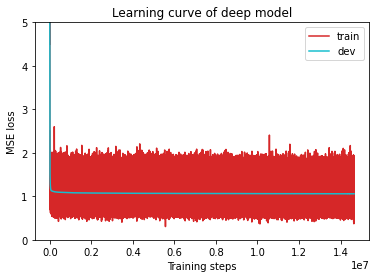

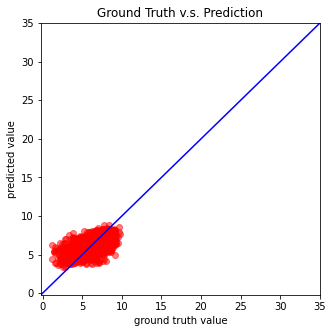

In [15]:
# Start Training
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)
plot_learning_curve(model_loss_record, title='deep model')

del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

In [16]:
preds = test(tt_set, model, device)  # predict COVID-19 cases with your model

### Test RMSE

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
mean_squared_error(tt_data[:,-1], preds, squared=False)

1.0879841110201125